# Laboratorio 1: Deteccion de Pishing
### Jose Hernandez
### Javier Mombiela

In [1]:
# Importar las librerias necesarias
import pandas as pd

In [2]:
# Cargue el dataset en un dataframe de pandas, muestre un ejemplo de cinco observaciones.
data = pd.read_csv("dataset_pishing.csv")

# Hacemos el describe para ver la distribución de los datos
print(data.describe())

# Hacemos el head para ver las primeras 5 filas
print(data.head())

                                                      url      status
count                                               11430       11430
unique                                              11429           2
top     http://e710z0ear.du.r.appspot.com/c:/users/use...  legitimate
freq                                                    2        5715
                                                 url      status
0              http://www.crestonwood.com/router.php  legitimate
1  http://shadetreetechnology.com/V4/validation/a...    phishing
2  https://support-appleld.com.secureupdate.duila...    phishing
3                                 http://rgipt.ac.in  legitimate
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate


In [3]:
# Muestre la cantidad de observaciones etiquetadas en la columna status como “legit” y como “pishing”. ¿Está balanceado el dataset?

print(data["status"].value_counts())

status
legitimate    5715
phishing      5715
Name: count, dtype: int64


### Derivación de características 
En base a los artículos propuestos de clasificación de phishing, responda las siguientes preguntas: 
1. ¿Qué ventajas tiene el análisis de una URL contra el análisis de otros datos, cómo el tiempo 
de vida del dominio, o las características de la página Web? 
2. ¿Qué características de una URL son más prometedoras para la detección de phishing?

### 1. Ventajas del Análisis de URL contra Otros Datos
Eficiencia y Accesibilidad: El análisis de URL permite una evaluación rápida y en tiempo real sin cargar la página, facilitando la detección preliminar de amenazas de forma eficiente.
Consistencia de Datos: Las URLs proporcionan información estática y directa, menos susceptible a cambios y manipulaciones, en contraste con el contenido dinámico de las páginas web que puede ser más fácilmente alterado para evadir la detección.

### 2. Características de una URL más Prometedoras para la Detección de Phishing
Dominios Mal Escritos y Uso de Subdominios: Las variaciones ortográficas sutiles en dominios y el uso excesivo de subdominios intentan imitar sitios legítimos para engañar a los usuarios, siendo indicativos clave de phishing.
Longitud de la URL y Presencia de Palabras Clave Sensibles: Las URLs anormalmente largas y la inclusión de términos relacionados con la seguridad o transacciones financieras pueden señalar intentos de phishing, buscando simular urgencia o legitimidad.

In [4]:
# Las URLs se pueden ver de la siguiente manera:

# http://www.crestonwood.com/router.php
# http://shadetreetechnology.com/V4/validation/a111aedc8ae390eabcfa130e041a10a4
# https://support-appleld.com.secureupdate.duilawyeryork.com/ap/89e6a3b4b063b8d/?cmd=_update&dispatch=89e6a3b4b063b8d1b&locale=_
# http://rgipt.ac.in
# http://www.iracing.com/tracks/gateway-motorsports-park/
# http://appleid.apple.com-app.es/
# http://www.mutuo.it
# http://www.shadetreetechnology.com/V4/validation/ba4b8bddd7958ecb8772c836c2969531
# http://vamoaestudiarmedicina.blogspot.com/
# https://parade.com/425836/joshwigler/the-amazing-race-host-phil-keoghan-previews-the-season-27-premiere/
# https://www.astrologyonline.eu/Astro_MemoNew/Profilo.asp

# Lo que quisiera es en mi dataframe agregar una columna que me diga que protocolo es, http o https y agregar una columna que me diga el dominio de la URL.

# Para esto, vamos a usar la libreria urllib.parse

from urllib.parse import urlparse

# Vamos a hacer una función que nos permita obtener el protocolo y el dominio de la URL

def get_protocol_and_domain(url):
    parsed_url = urlparse(url)
    return parsed_url.scheme, parsed_url.netloc

# Ahora vamos a aplicar la función a la columna de URLs

data["protocol"], data["domain"] = zip(*data["url"].map(get_protocol_and_domain))

# Ahora vamos a ver como quedo el dataframe

# print(data.head())

# Ahora de acuerdo a los dominios que pueden ser:

# www.crestonwood.com  
# shadetreetechnology.com  
# support-appleld.com.secureupdate.duilawyeryork.com
# rgipt.ac.in  
# www.iracing.com 

# Creamos una columna con sus subdomains si es que los tienen

# Creamos una columna con second level domain si es que los tienen

# Creamos una columna con el top level domain


def get_subdomain_and_sld_and_tld(domain):

    domain_parts = domain.split(".")
    if len(domain_parts) == 2:
        return None, domain_parts[0], domain_parts[1]
    elif len(domain_parts) == 3:
        return domain_parts[0], domain_parts[1], domain_parts[2]
    else:
        return domain_parts[0], domain_parts[1], domain_parts[2]
    
data["subdomain"], data["secondleveldomain"], data["topleveldomain"] = zip(*data["domain"].map(get_subdomain_and_sld_and_tld))

# Ahora vamos a ver como quedo el dataframe

print(data.head())

                                                 url      status protocol  \
0              http://www.crestonwood.com/router.php  legitimate     http   
1  http://shadetreetechnology.com/V4/validation/a...    phishing     http   
2  https://support-appleld.com.secureupdate.duila...    phishing    https   
3                                 http://rgipt.ac.in  legitimate     http   
4  http://www.iracing.com/tracks/gateway-motorspo...  legitimate     http   

                                              domain        subdomain  \
0                                www.crestonwood.com              www   
1                            shadetreetechnology.com             None   
2  support-appleld.com.secureupdate.duilawyeryork...  support-appleld   
3                                        rgipt.ac.in            rgipt   
4                                    www.iracing.com              www   

     secondleveldomain topleveldomain  
0          crestonwood            com  
1  shadetreetechno

In [5]:
def url_length(url):
    """Check if the URL length is suspiciously long."""
    return len(url) > 75

def has_https(url):
    """Check if the URL uses HTTPS."""
    return url.startswith('https://')

def suspicious_tld(url):
    """Check for suspicious Top-Level Domains."""
    suspicious_domains = ['.biz', '.info', '.top', '.xyz']
    return any(url.endswith(domain) for domain in suspicious_domains)

def subdomain_count(url):
    """Count the number of subdomains."""
    domain = url.split("//")[-1].split("/")[0]
    return domain.count('.') - (1 if 'www.' not in domain else 0)

def contains_ip_address(url):
    """Check if the URL contains an IP address instead of a domain."""
    import re
    ip_pattern = r'\b(?:[0-9]{1,3}\.){3}[0-9]{1,3}\b'
    return bool(re.search(ip_pattern, url))

def path_length(url):
    """Check if the URL path is suspiciously long."""
    path = url.split('//')[-1].split('/')[1:]
    return len("/".join(path)) > 75

def contains_at_symbol(url):
    """Check if '@' symbol is present in the URL."""
    return "@" in url

def special_characters_count(url):
    """Count the number of special characters."""
    import re
    return len(re.findall(r'\W', url)) - url.count('/') - url.count('.')

def https_in_domain(url):
    """Check for 'https' in the domain name."""
    domain = url.split("//")[-1].split("/")[0]
    return 'https' in domain and not domain.startswith('https')

def sensitive_words(url):
    """Check for sensitive words in the URL."""
    words = ['login', 'verify', 'bank']
    return any(word in url for word in words)

def domain_age_check(url):
    """Stub for checking domain age, requires external API."""
    return False

def dot_count(url):
    """Count the number of dots in the URL."""
    return url.count('.')

def port_in_url(url):
    """Check if a port is specified in the URL."""
    import re
    port_pattern = r':\d+'
    return bool(re.search(port_pattern, url.split('/')[2] if '://' in url else url))

def file_extension_check(url):
    """Check for suspicious file extensions."""
    suspicious_extensions = ['.exe', '.zip', '.rar']
    return any(url.endswith(ext) for ext in suspicious_extensions)

def brand_name_in_domain(url):
    """Stub for checking brand names in domain, requires list of brand names."""
    return False



# Por cada una de las urls en el dataframe vamos a aplicar las funciones anteriores y vamos a guardar los resultados en un diccionario y posteriormente en columnas del mismo dataframe.

results = []

for i in range(len(data)):

    fila = data.iloc[i]
    test_url = fila["url"]

    # Test functions
    result = {
        "url_length_gt_75": url_length(test_url),
        "has_https": has_https(test_url),
        "suspicious_tld": suspicious_tld(test_url),
        "subdomain_count": subdomain_count(test_url),
        "contains_ip_address": contains_ip_address(test_url),
        "path_length": path_length(test_url),
        "contains_at_symbol": contains_at_symbol(test_url),
        "special_characters_count": special_characters_count(test_url),
        "https_in_domain": https_in_domain(test_url),
        "sensitive_words": sensitive_words(test_url),
        "domain_age_check": domain_age_check(test_url),
        "dot_count": dot_count(test_url),
        "port_in_url": port_in_url(test_url),
        "file_extension_check": file_extension_check(test_url),
        "brand_name_in_domain": brand_name_in_domain(test_url),
    }

    # Convertir valores booleanos a int para evitar el FutureWarning
    result = {k: int(v) if isinstance(v, bool) else v for k, v in result.items()}

    # Actualizar la fila correspondiente en el DataFrame con los resultados
    for key, value in result.items():
        data.at[i, key] = value  # Cambié 'loc' a 'at' para asignación directa, aunque 'loc' también es correcto.


# Ahora vamos a ver como quedo el dataframe
        
data.head()


,url,status,protocol,domain,subdomain,secondleveldomain,topleveldomain,url_length_gt_75,has_https,suspicious_tld,...,path_length,contains_at_symbol,special_characters_count,https_in_domain,sensitive_words,domain_age_check,dot_count,port_in_url,file_extension_check,brand_name_in_domain
0,http://www.crestonwood.com/router.php,legitimate,http,www.crestonwood.com,www,crestonwood,com,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1,http://shadetreetechnology.com/V4/validation/a...,phishing,http,shadetreetechnology.com,None,shadetreetechnology,com,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,https://support-appleld.com.secureupdate.duila...,phishing,https,support-appleld.com.secureupdate.duilawyeryork...,support-appleld,com,secureupdate,1.0,1.0,0.0,...,0.0,0.0,8.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
3,http://rgipt.ac.in,legitimate,http,rgipt.ac.in,rgipt,ac,in,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,http,www.iracing.com,www,iracing,com,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0


In [6]:
def converted_status(status):
    if status.lower() == "phishing":
        return 1
    else:
        return 0

data["binary_status"] = data["status"].apply(converted_status)

# Ahora vamos a ver como quedo el dataframe

data.head(30)

,url,status,protocol,domain,subdomain,secondleveldomain,topleveldomain,url_length_gt_75,has_https,suspicious_tld,...,contains_at_symbol,special_characters_count,https_in_domain,sensitive_words,domain_age_check,dot_count,port_in_url,file_extension_check,brand_name_in_domain,binary_status
0,http://www.crestonwood.com/router.php,legitimate,http,www.crestonwood.com,www,crestonwood,com,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
1,http://shadetreetechnology.com/V4/validation/a...,phishing,http,shadetreetechnology.com,None,shadetreetechnology,com,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1
2,https://support-appleld.com.secureupdate.duila...,phishing,https,support-appleld.com.secureupdate.duilawyeryork...,support-appleld,com,secureupdate,1.0,1.0,0.0,...,0.0,8.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,1
3,http://rgipt.ac.in,legitimate,http,rgipt.ac.in,rgipt,ac,in,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,http,www.iracing.com,www,iracing,com,0.0,0.0,0.0,...,0.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
5,http://appleid.apple.com-app.es/,phishing,http,appleid.apple.com-app.es,appleid,apple,com-app,0.0,0.0,0.0,...,0.0,2.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1
6,http://www.mutuo.it,legitimate,http,www.mutuo.it,www,mutuo,it,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
7,http://www.shadetreetechnology.com/V4/validati...,phishing,http,www.shadetreetechnology.com,www,shadetreetechnology,com,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1
8,http://vamoaestudiarmedicina.blogspot.com/,legitimate,http,vamoaestudiarmedicina.blogspot.com,vamoaestudiarmedicina,blogspot,com,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0
9,https://parade.com/425836/joshwigler/the-amazi...,legitimate,https,parade.com,None,parade,com,1.0,1.0,0.0,...,0.0,11.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


### Visualización de resultados 

Genere un reporte de perfil con la librería pandas_profiling. Analice el reporte y determine las 
columnas que son constantes, o que no tienen una varianza alta con la columna status. Almacene su 
reporte como una página html.

In [ ]:
import pandas as pd
import sweetviz as sv

# Leer el dataset

dataset_profiling = pd.read_csv("dataset_pishing.csv")

# Crear el reporte

reporte = sv.analyze(dataset_profiling)

# Mostar el reporte en el jupyter notebook

reporte.show_notebook()

# Guardar el reporte en un archivo HTML

reporte.show_html("reporte_profiling.html")

### Selección de Características 
En base al análisis del reporte, elimine las características repetidas o irrelevantes para la clasificación 
de un sitio de phishing. Verifique que no posee observaciones repetidas. 

In [7]:
# Limpiamos el dataframe de las columnas que no necesitamos o consideramos que no aportan información

data = data.drop(columns=["sensitive_words", "domain_age_check", "port_in_url", "file_extension_check", "brand_name_in_domain"])

# Ahora vamos a ver como quedo el dataframe

data.head(30)

,url,status,protocol,domain,subdomain,secondleveldomain,topleveldomain,url_length_gt_75,has_https,suspicious_tld,subdomain_count,contains_ip_address,path_length,contains_at_symbol,special_characters_count,https_in_domain,dot_count,binary_status
0,http://www.crestonwood.com/router.php,legitimate,http,www.crestonwood.com,www,crestonwood,com,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,0
1,http://shadetreetechnology.com/V4/validation/a...,phishing,http,shadetreetechnology.com,None,shadetreetechnology,com,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1
2,https://support-appleld.com.secureupdate.duila...,phishing,https,support-appleld.com.secureupdate.duilawyeryork...,support-appleld,com,secureupdate,1.0,1.0,0.0,3.0,0.0,0.0,0.0,8.0,0.0,4.0,1
3,http://rgipt.ac.in,legitimate,http,rgipt.ac.in,rgipt,ac,in,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate,http,www.iracing.com,www,iracing,com,0.0,0.0,0.0,2.0,0.0,0.0,0.0,3.0,0.0,2.0,0
5,http://appleid.apple.com-app.es/,phishing,http,appleid.apple.com-app.es,appleid,apple,com-app,0.0,0.0,0.0,2.0,0.0,0.0,0.0,2.0,0.0,3.0,1
6,http://www.mutuo.it,legitimate,http,www.mutuo.it,www,mutuo,it,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0
7,http://www.shadetreetechnology.com/V4/validati...,phishing,http,www.shadetreetechnology.com,www,shadetreetechnology,com,1.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,1
8,http://vamoaestudiarmedicina.blogspot.com/,legitimate,http,vamoaestudiarmedicina.blogspot.com,vamoaestudiarmedicina,blogspot,com,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
9,https://parade.com/425836/joshwigler/the-amazi...,legitimate,https,parade.com,None,parade,com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,11.0,0.0,1.0,0


### Parte 2 – Implementación 
Separación de datos 
• Datos de entrenamiento: 55% 
• Datos de validación: 15% 
• Datos de prueba: 30% 
• Almacene cada dataset como un archivo .csv

In [8]:
# Separación de datos 
# • Datos de entrenamiento: 55% 
# • Datos de validación: 15% 
# • Datos de prueba: 30% 
# • Almacene cada dataset como un archivo .csv

from sklearn.model_selection import train_test_split

# Dividir el dataset en tres partes: entrenamiento (55% del dataset actual), validación (15% del dataset actual) y prueba (30% del dataset actual)

# Dividir el dataset en entrenamiento y prueba

train, test = train_test_split(data, test_size=0.3, random_state=42)

# Dividir el dataset de entrenamiento en entrenamiento y validación

train, val = train_test_split(train, test_size=0.15, random_state=42)

# Guardar los datasets en archivos .csv

train.to_csv("train.csv", index=False)

val.to_csv("val.csv", index=False)

test.to_csv("test.csv", index=False)

# Ahora vamos a ver como quedo el dataframe

print("Datos de entrenamiento")
train.head(10)

print("Datos de validación")
val.head(10)

print("Datos de prueba")
test.head(10)

Datos de entrenamiento
Datos de validación
Datos de prueba


,url,status,protocol,domain,subdomain,secondleveldomain,topleveldomain,url_length_gt_75,has_https,suspicious_tld,subdomain_count,contains_ip_address,path_length,contains_at_symbol,special_characters_count,https_in_domain,dot_count,binary_status
7529,https://www.rga.com/about/workplace,legitimate,https,www.rga.com,www,rga,com,0.0,1.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0
11221,http://starasia.com.hk,legitimate,http,starasia.com.hk,starasia,com,hk,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
4889,https://www.youtube.com/watch?v=XszqITK-UEw,legitimate,https,www.youtube.com,www,youtube,com,0.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,2.0,0
8962,http://www.civico1845.com/,legitimate,http,www.civico1845.com,www,civico1845,com,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,2.0,0
4004,http://rapidpaws.com/wp-content/we_transfer/in...,phishing,http,rapidpaws.com,None,rapidpaws,com,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,1
3265,https://mykoreankitchen.com/dak-galbi/,legitimate,https,mykoreankitchen.com,None,mykoreankitchen,com,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0
11235,http://support-appleld.com.secureupdate.duilaw...,phishing,http,support-appleld.com.secureupdate.duilawyeryork...,support-appleld,com,secureupdate,1.0,0.0,0.0,3.0,0.0,0.0,0.0,8.0,0.0,4.0,1
8897,http://quiluc.com.vn,legitimate,http,quiluc.com.vn,quiluc,com,vn,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
900,http://www.astro.com/astrology/tma_article1607...,legitimate,http,www.astro.com,www,astro,com,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,3.0,0
7856,https://huggybearheadcanon.tumblr.com/#_=_,legitimate,https,huggybearheadcanon.tumblr.com,huggybearheadcanon,tumblr,com,0.0,1.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,2.0,0


### Utilice dos algoritmos de Machine Learning para entrenar el modelo.
Muestre y explique los valores obtenidos de las siguientes métricas para los datos de validación y pruebas, para cada modelo, en 
base al contexto del problema (detección de Pishing). 
• Matriz de confusión 
• Precision 
• Recall 
• Curva ROC 
• AUC

In [9]:
# Utiilizamos dos algoritmos de machine learning para entrenar el modelo. Los algoritmos que vamos a utilizar son:

# • Random Forest

# • Gradient Boosting

# Vamos a entrenar el modelo con Random Forest

from sklearn.ensemble import RandomForestClassifier

# Definir las características que vamos a utilizar para entrenar el modelo

features = [
    "url_length_gt_75",
    "has_https",
    "suspicious_tld",
    "subdomain_count",
    "contains_ip_address",
    "path_length",
    "contains_at_symbol",
    "special_characters_count",
    "https_in_domain",
    "dot_count",
]

# Definir la variable objetivo

target = "binary_status"

# Crear el modelo

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entrenar el modelo

model.fit(train[features], train[target])

# Ahora vamos a evaluar el modelo con el dataset de validación

from sklearn.metrics import accuracy_score

# Predecir el dataset de validación

val_predictions = model.predict(val[features])

# Calcular la precisión del modelo

accuracy = accuracy_score(val[target], val_predictions)

print(f"La precisión del modelo es: {accuracy:.4f}")

La precisión del modelo es: 0.7652


In [10]:
# Vamos a entrenar el modelo con Gradient Boosting

from sklearn.ensemble import GradientBoostingClassifier

# Crear el modelo

model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo

model.fit(train[features], train[target])

# Ahora vamos a evaluar el modelo con el dataset de validación

# Predecir el dataset de validación

val_predictions = model.predict(val[features])

# Calcular la precisión del modelo

accuracy = accuracy_score(val[target], val_predictions)

print(f"La precisión del modelo es: {accuracy:.4f}")

La precisión del modelo es: 0.7594


Matriz de confusión
[[462 150]
 [132 457]]


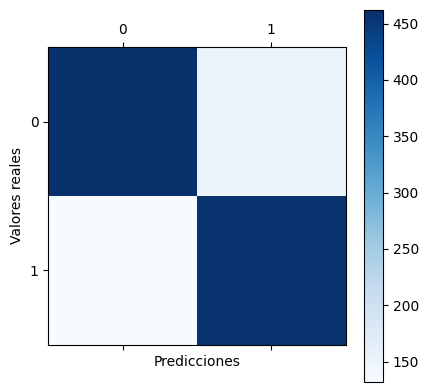

Precision: 0.7529
Recall: 0.7759
AUC: 0.7654


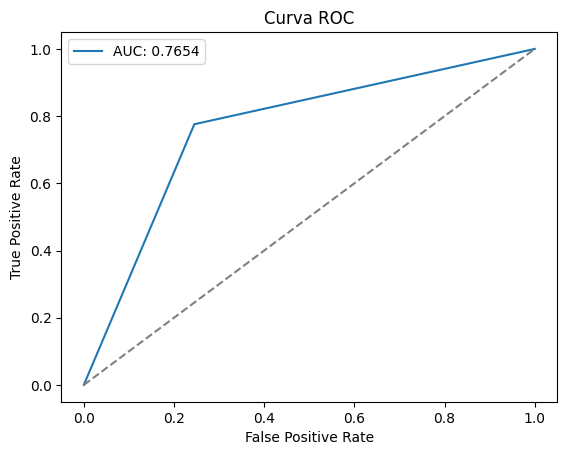

In [14]:
# Mostramos y explicamos los valores obtenidos de las siguientes métricas para los datos de validación y pruebas, para cada modelo, en base al contexto del problema (detección de Pishing). 
# • Matriz de confusión 
# • Precision 
# • Recall 
# • Curva ROC 
# • AUC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, roc_auc_score

# Definir las características que vamos a utilizar para entrenar el modelo

features = [
    "url_length_gt_75",
    "has_https",
    "suspicious_tld",
    "subdomain_count",
    "contains_ip_address",
    "path_length",
    "contains_at_symbol",
    "special_characters_count",
    "https_in_domain",
    "dot_count",
]

# Definir la variable objetivo

target = "binary_status"

# Crear el modelo

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Entrenar el modelo

model.fit(train[features], train[target])

# Predecir el dataset de validación

val_predictions = model.predict(val[features])

# Calcular la matriz de confusión

conf_matrix = confusion_matrix(val[target], val_predictions)

print("Matriz de confusión")

print(conf_matrix)

# Ilustramos la matriz de confusión con matplotlib para que sea más fácil de interpretar

import matplotlib.pyplot as plt

plt.matshow(conf_matrix, cmap="Blues")

plt.colorbar()

plt.xlabel("Predicciones")

plt.ylabel("Valores reales")

plt.show()

# Calcular la precisión

precision = precision_score(val[target], val_predictions)

print(f"Precision: {precision:.4f}")

# Calcular el recall

recall = recall_score(val[target], val_predictions)

print(f"Recall: {recall:.4f}")

# Calcular la curva ROC

fpr, tpr, thresholds = roc_curve(val[target], val_predictions)

# Calcular el AUC

auc = roc_auc_score(val[target], val_predictions)

print(f"AUC: {auc:.4f}")

# Crear un gráfico de la curva ROC

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}")

plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.title("Curva ROC")

plt.legend()

plt.show()

##### Análisis de las métricas obtenidas con Random Forrest

El modelo Random Forest muestra un rendimiento sólido en la detección de phishing según las métricas proporcionadas. Con una precisión del 75.29%, significa que aproximadamente tres cuartas partes de las URL clasificadas como legítimas son realmente legítimas. Su recall del 77.59% indica que detecta correctamente alrededor del 77.59% de las URLs legítimas presentes en el conjunto de datos. La métrica AUC, que mide la capacidad de discriminación del modelo, es 0.7654, lo que sugiere que el modelo tiene una buena capacidad para distinguir entre las clases de phishing y legítimas. Esta capacidad se refleja en la curva ROC, donde el área bajo la curva (AUC) representa la probabilidad de que el modelo clasifique una instancia aleatoria positiva más alta que una instancia aleatoria negativa.

Matriz de confusión
[[459 153]
 [136 453]]


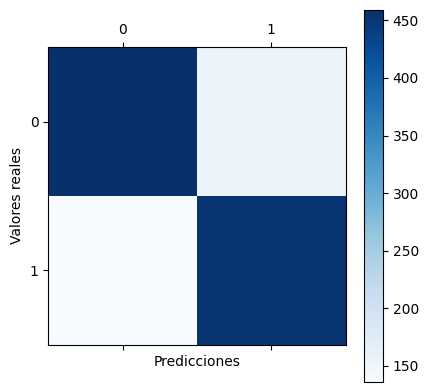

Precision: 0.7475
Recall: 0.7691
AUC: 0.7596


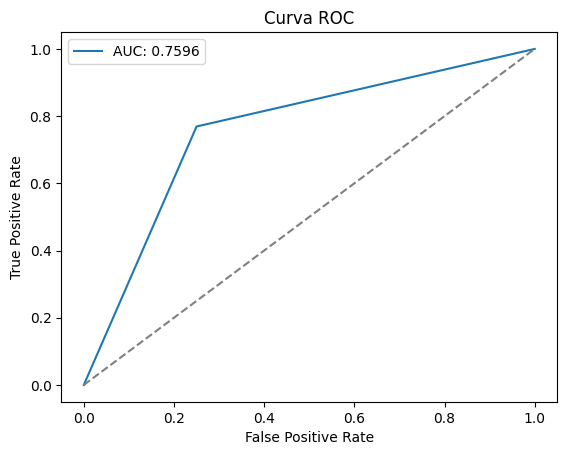

In [15]:
# Entrenar el modelo con Gradient Boosting

# Crear el modelo

model = GradientBoostingClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo

model.fit(train[features], train[target])

# Predecir el dataset de validación

val_predictions = model.predict(val[features])

# Calcular la matriz de confusión

conf_matrix = confusion_matrix(val[target], val_predictions)

print("Matriz de confusión")

print(conf_matrix)

# Ilustramos la matriz de confusión con matplotlib para que sea más fácil de interpretar

import matplotlib.pyplot as plt

plt.matshow(conf_matrix, cmap="Blues")

plt.colorbar()

plt.xlabel("Predicciones")

plt.ylabel("Valores reales")

plt.show()

# Calcular la precisión

precision = precision_score(val[target], val_predictions)

print(f"Precision: {precision:.4f}")

# Calcular el recall

recall = recall_score(val[target], val_predictions)

print(f"Recall: {recall:.4f}")

# Calcular la curva ROC

fpr, tpr, thresholds = roc_curve(val[target], val_predictions)

# Calcular el AUC

auc = roc_auc_score(val[target], val_predictions)

print(f"AUC: {auc:.4f}")

# Crear un gráfico de la curva ROC

import matplotlib.pyplot as plt

plt.plot(fpr, tpr, label=f"AUC: {auc:.4f}")

plt.plot([0, 1], [0, 1], "--", color="gray")

plt.xlabel("False Positive Rate")

plt.ylabel("True Positive Rate")

plt.title("Curva ROC")

plt.legend()

plt.show()

##### Análisis de las métricas obtenidas con Gradient Boosting

El modelo Gradient Boosting también muestra un rendimiento competitivo en la tarea de detección de phishing. Con una precisión del 74.75%, el modelo identifica correctamente aproximadamente el 74.75% de las URL clasificadas como legítimas. Su recall del 76.91% indica que detecta correctamente alrededor del 76.91% de las URLs legítimas en el conjunto de datos. Aunque ligeramente inferior al Random Forest, sigue siendo una métrica sólida. El AUC de 0.7596 sugiere que el modelo tiene una capacidad decente para discriminar entre las clases. La curva ROC proporciona una visualización adicional de cómo el modelo clasifica las instancias, donde una curva ROC más cercana al borde superior izquierdo del gráfico indica un mejor rendimiento del modelo.

### Discusión 





#### Impacto de clasificar un sitio legítimo como phishing (Falso Positivo)

Clasificar un sitio legítimo como phishing puede tener consecuencias negativas, tanto para el propietario del sitio como para los usuarios. Para el propietario del sitio, esto puede significar una pérdida de tráfico y de confianza, lo que a su vez puede traducirse en una disminución de ingresos o reputación. Para los usuarios, puede generar inconvenientes al intentar acceder a contenido legítimo, creando una experiencia de usuario frustrante y potencialmente llevándolos a dudar de la fiabilidad de futuras advertencias de seguridad.





#### Impacto de clasificar un sitio de phishing como legítimo (Falso Negativo)
El impacto de clasificar un sitio de phishing como legítimo es potencialmente más grave, ya que expone a los usuarios a riesgos significativos de seguridad, como el robo de identidad, la pérdida de información personal o financiera, y la instalación de malware en sus dispositivos. Esto puede tener consecuencias duraderas para los usuarios afectados y puede deteriorar la confianza en los sistemas de detección de phishing.




#### Métrica para comparar modelos similares de clasificación de phishing

Dado el contexto de detección de phishing, donde el coste de un falso negativo (no detectar un sitio de phishing) puede ser mucho mayor que el de un falso positivo (bloquear un sitio legítimo), sería prudente priorizar métricas que se enfoquen en la capacidad del modelo para detectar correctamente los sitios de phishing. En este sentido, el Recall (también conocido como sensibilidad) podría ser la métrica más relevante, ya que mide la proporción de sitios de phishing reales que fueron identificados correctamente como tales por el modelo. Sin embargo, esto no significa ignorar completamente la precisión y otras métricas, ya que un equilibrio es muy importante para asegurar que no se bloqueen excesivamente los sitios legítimos o que no presentan riesgos.

#### ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué? 

Comparando el Recall y el AUC (Área Bajo la Curva ROC) de ambos modelos:

 - RandomForestClassifier tiene un Recall de 0.7759 y un AUC de 0.7654.
 - GradientBoostingClassifier tiene un Recall de 0.7691 y un AUC de 0.7596.

El RandomForestClassifier tiene un Recall y un AUC ligeramente superiores, lo que indica que es mejor para detectar sitios de phishing sin dejar de lado el equilibrio general entre falsos positivos y falsos negativos. Por tanto, basándonos en estos resultados, el RandomForestClassifier funcionó mejor para la clasificación de phishing.

### Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes 
### ataques de phishing mediante e-mail. La empresa estima que, de un total de 50,000 emails, 
### un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y 
### cuantas negativas? ¿Funciona el modelo para el BR propuesto? En caso negativo, ¿qué se 
### podría hacer para reducir la cantidad de falsas alarmas?

Con un 15% de los 50,000 emails estimados como phishing, tenemos:

Emails de phishing: 15% de 50,000 = 7,500 emails.
Emails legítimos: 85% de 50,000 = 42,500 emails.
Para calcular la cantidad de alarmas generadas, utilizaremos el rendimiento del RandomForestClassifier (mejor modelo según el análisis previo), pero necesitamos convertir las métricas de precisión y recall en números absolutos de clasificaciones correctas e incorrectas para este volumen específico de emails.

Calculamos lo siguiente asumiendo que el rendimiento del modelo en el dataset de prueba será similar en el nuevo conjunto de datos:

Falsos Positivos (FP): Clasificar emails legítimos como phishing.
Verdaderos Positivos (TP): Clasificar correctamente emails de phishing como tales.
Falsos Negativos (FN): No detectar emails de phishing, clasificándolos como legítimos.
Verdaderos Negativos (TN): Clasificar correctamente emails legítimos como tales.

Para reducir las falsas alarmas, se podrían implementar medidas como ajustar el umbral de decisión del modelo para favorecer la reducción de falsos positivos, mejorar la calidad de los datos de entrenamiento, o utilizar técnicas de aprendizaje semi-supervisado o no supervisado que puedan adaptarse mejor a la variabilidad de los emails. Además, se puede emplear un sistema de revisión manual para los casos dudosos o implementar soluciones de capas adicionales, como la verificación de dos pasos para los usuarios al acceder a sitios marcados con cierto nivel de riesgo.

In [16]:
# Datos proporcionados
emails_totales = 50000
porcentaje_phishing = 0.15
porcentaje_legitimo = 0.85

# Cantidad estimada de emails
emails_phishing = emails_totales * porcentaje_phishing
emails_legitimos = emails_totales * porcentaje_legitimo

# Rendimiento del RandomForestClassifier
# Estos son valores estimados basados en las métricas de precisión y recall proporcionadas
precision_random_forest = 0.7529
recall_random_forest = 0.7759

# Cálculo de TP, FP, FN, TN
# TP: Verdaderos Positivos - emails de phishing correctamente identificados
tp = recall_random_forest * emails_phishing

# FN: Falsos Negativos - emails de phishing no detectados
fn = emails_phishing - tp

# La precisión se calcula como TP / (TP + FP), despejamos FP
fp = tp / precision_random_forest - tp

# TN: Verdaderos Negativos - emails legítimos correctamente identificados
tn = emails_legitimos - fp

tp, fp, fn, tn


(5819.25, 1909.8640921769156, 1680.75, 40590.13590782308)

Verdaderos Positivos (TP) - 5,819.25: 

Esta cifra indica que el modelo fue capaz de identificar correctamente aproximadamente 5,819 emails de phishing, reflejando su eficacia en la detección y prevención de amenazas de seguridad.

Falsos Positivos (FP) - 1,909.86: 

Este número muestra que alrededor de 1,910 emails legítimos fueron incorrectamente marcados como phishing, lo que puede llevar a inconvenientes y requerir revisión manual, afectando la productividad.

Falsos Negativos (FN) - 1,680.75: 

Significa que aproximadamente 1,681 emails de phishing no fueron detectados por el modelo y clasificados como seguros, representando un riesgo de seguridad al permitir que estas amenazas potenciales pasen desapercibidas.

Verdaderos Negativos (TN) - 40,590.14: 

Esta cifra indica que el modelo identificó correctamente alrededor de 40,590 emails legítimos como tales, demostrando su capacidad para minimizar interrupciones al permitir que el tráfico legítimo proceda sin obstáculos.